SETUP AND INSTALLATIONS

In [20]:
# Install required packages
!pip install torch torchvision matplotlib opencv-python

In [21]:
# Imports
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import zipfile
from tqdm import tqdm
from PIL import Image

In [22]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"CUDA Version: {torch.version.cuda}")

Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6


 DATASET

In [23]:
# Verify dataset structure
dataset_path = '/content/drive/MyDrive/dataset-resized' # data/dataset-resized
if os.path.exists(dataset_path):
    classes = os.listdir(dataset_path)
    print(f"Dataset classes: {classes}")
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            print(f"{class_name}: {count} images")
else:
    print("Dataset not found!")

Dataset classes: ['glass', 'metal', 'trash', 'paper', 'plastic', 'cardboard']
glass: 501 images
metal: 410 images
trash: 137 images
paper: 594 images
plastic: 482 images
cardboard: 403 images


DATA PREPROCESSING AND AUGMENTATION

In [ ]:
# Define data transformations
def get_transforms():
    """Get data transformations for training and validation"""

    # Training transforms with augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation transforms (no augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transforms, val_transforms

# Custom Dataset class for better control
class TrashNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.samples = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(class_path, img_name), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image if loading fails
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, label

In [24]:
# Instantiate the dataset
dataset_path = '/content/drive/MyDrive/dataset-resized' # data/dataset-resized
train_transforms, val_transforms = get_transforms()
dataset = TrashNetDataset(root_dir=dataset_path, transform=train_transforms)

Train/Val/Test split

In [25]:
total_size = len(dataset)
val_size = int(0.2 * total_size)
test_size = int(0.1 * total_size)
train_size = total_size - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 1770, Val size: 505, Test size: 252


Function to denormalize & show images

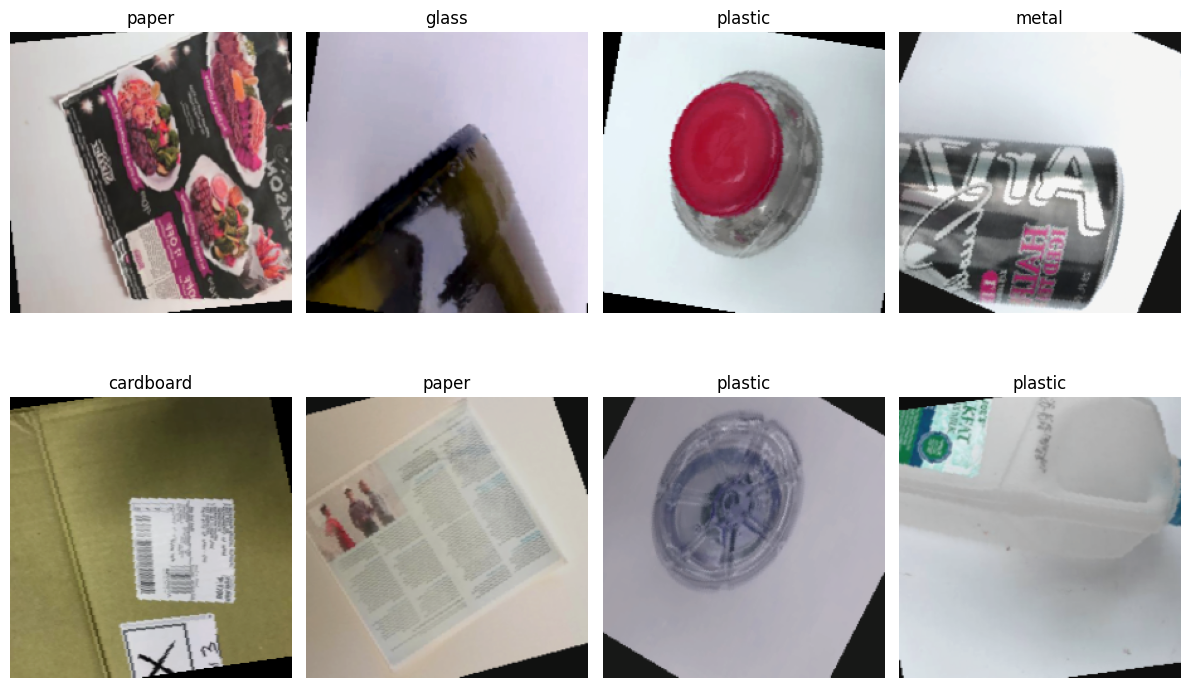

In [30]:
# Reproducibility (optional)
torch.manual_seed(42)
np.random.seed(42)
classes = train_ds.dataset.classes
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def denorm(img_tensor):
    """img_tensor: (C,H,W) normalized; returns (H,W,C) in [0,1]"""
    x = inv_normalize(img_tensor.clone())
    x = x.clamp(0, 1)
    return x.permute(1, 2, 0).cpu().numpy()

def show_batch(loader, classes, n=8):
    imgs, labels = next(iter(loader))
    n = min(n, imgs.size(0))
    plt.figure(figsize=(12, 8))
    for i in range(n):
        ax = plt.subplot(2, 4, i+1)
        img_np = denorm(imgs[i])
        ax.imshow(img_np)
        ax.set_title(classes[int(labels[i].item())])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a batch
show_batch(train_loader, classes, n=8)